# Cavity Eigenmodes

Optical cavities, such as Fabry-Perot cavities, typically have a complex mix of both longitudinal and traverse resonant modes. The properties of such modes is usually characterised by the free spectral range and the accumulated roundtrip gouy phase cavity parameters. Using these parameters you can determine how each transverse mode will resonate relative to other optical modes and frequencies. 

This simple analysis isn't however easily applicable to more complex scenarios where optical defects are present in the cavity. In such cases the usual Hermite-Gaussian modal basis no longer describes the system and each higher order mode can experience different losses.

FINESSE contains tools to analyse such effects. One of these is the **eigenmode** analysis. This analysis calculates the round trip matrix operator in the Hermite-Gaussian basis and performs an eigen-decomposition on it to determine the eigenvalues and eigenvectors. The eigenvalues provide information about the relative phases and amplitudes of each resonant mode of the cavity. The eigenvectors tell us what mix of HG modes make up a particular resonance. This type of analysis is a much faster way to study the resonances of a cavity compared to scanning the cavity length or laser frequency whilst injecting higher order modes, as is typically done with other tools and with older versions of FINESSE.

We start with a simple optical cavity based on an Advanced LIGO arm cavity:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
from finesse.knm import Map
from finesse.utilities.maps import circular_aperture

finesse.init_plotting()

model = finesse.Model()
model.parse(
    """
    l l1
    mod mod1 f=9.1M midx=0.1
    m m1 R=0.984 T=0.014 Rc=-1940
    m m2 R=1 T=0 Rc=2245
    link(l1, mod1, m1, 3994, m2)
    cav cavity m2.p1.o
    modes(maxtem=2)

    fd E_arm m2.p1.i l1.f  # Field detector
    """
)

We have included HG modes up to order 2 and also a field detector to output the HG mode content within the arm.

The **eigenmode** analysis is simple to call as shown below. For this simulation we are running multiple eigenmode analyses at the frequency of the carrier and those of two radio-frequency sidebands. Lastly we perform a typical cavity scan using **xaxis**.

In [2]:
sol = model.run(
    """
    series(
        eigenmodes(cavity, -mod1.f, name="l9"),
        eigenmodes(cavity, 0,       name="c0"),
        eigenmodes(cavity, mod1.f,  name="u9"),
        xaxis(m2.phi, lin, -10, 190, 500, name="scan")
    )
    """
)

print(sol)

- Solution Tree
○ series - SeriesSolution
├──○ l9 - EigenmodesSolution
├──○ c0 - EigenmodesSolution
├──○ u9 - EigenmodesSolution
╰──● scan - ArraySolution


The overall **series** solution then contains the solutions for each of the analyses it contains. As we have given names to the analyses we can access each one by name using e.g. **sol["scan"]**, **sol["c0"]**, etc.

In [3]:
sol_c0 = sol["c0"]

> Note: We can access documentation for the **EigenmodesSolution** using **help(sol_c0)** or, if in an interactive termal such as IPython, **sol_c0??**.

We can see this has returned multiple outputs, such as the round-trip matrix operator which we perform the eigen-decomposition on along with various other outputs.

The **xaxis** cavity scan can be plotted using:

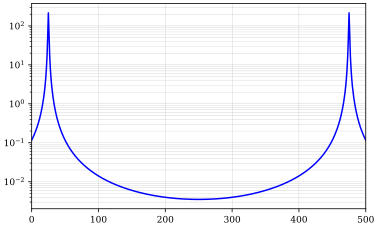

In [4]:
plt.semilogy(abs(sol["scan"]["E_arm"])**2);

where we can see that only a single mode is present. This is to be expected as we have a perfect optical system; likewise, if we print the eigenvalues and eigenvectors, we see we have an identity matrix of vectors.

In [5]:
sol["c0"].eigvectors

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

and each eigenvalue is identical in magnitude with a differing phase.

In [6]:
print(abs(sol["c0"].eigvalues))
print(np.angle(sol["c0"].eigvalues))

[0.99196774 0.99196774 0.99196774 0.99196774 0.99196774 0.99196774]
[ 0.         -0.86362061 -0.86362061 -1.72724122 -1.72724122 -1.72724122]


The phase difference between each mode is just the round-trip guoy phase difference between each mode order. 

The eigenvalue amplitude tells us about the roundtrip loss of the eigenmode. The power loss in the i-th eigenmode is simple: $$L_{i,rt} = 1 - \vert \gamma_i \vert^2$$ which in this case, is just equal to the transmission of our input mirror as that is the only source of loss.

When you have an array of HG mode amplitudes, the optical field can be plotted easily using the utility function **plot_field()**. This can be used to visually inspect each mode. We should see the usual HG eigenmodes.

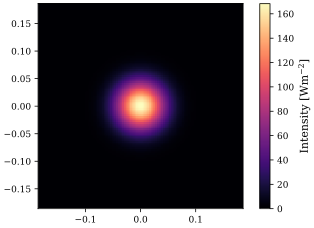

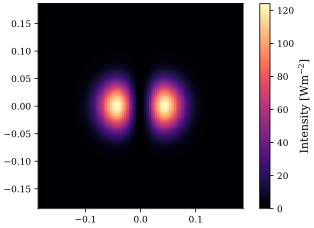

In [7]:
from finesse.plotting import plot_field

plot_field(
    model.homs,
    sol["c0"].eigvectors[:, 0],
    model.cavity.source.q
)
plot_field(
    model.homs,
    sol["c0"].eigvectors[:, 1],
    model.cavity.source.q
)

## Adding Defects

The most dominant effect that determines the eigenmodes of an optical cavity is the shape of mirror apertures.

This type of complex features is able to me simulated with FINESSE using *maps*. These describe the amplitude and phase offsets that an optical field experiences when interacting with an element. We can create an amplitude aperture that is similar to the Advanced LIGO mirror shape. A value of **1** means the beam is left unchanged and **0** attenuates it.

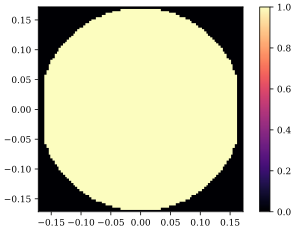

In [8]:
x = y = np.linspace(-0.17, 0.17, 100)
ligo_ap = circular_aperture(x, y, 0.17)
ligo_ap[:, abs(y) >= 0.163] = 0
model.m1.surface_map = Map(x, y, amplitude=ligo_ap)
model.m2.surface_map = Map(x, y, amplitude=ligo_ap)

# Plot the aperture we are applying.
plt.pcolormesh(x, y, ligo_ap, rasterized=True, shading="auto")
plt.gca().set_aspect("equal")
plt.colorbar();

Note that the Advanced LIGO mirrors are not perfectly round as they have flat edges on which the suspension wires are attached. 

With the finite aperatures added we can then re-run the eigenmode analysis and plot each eigenmode. We should see that we do not have perfect HG modes anymore. They are actually a more complex mix of Laugerre and Hermite Gaussian modes, due to the combination of circular aperture with the flat edges.

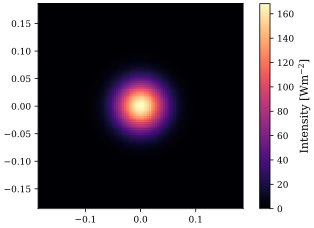

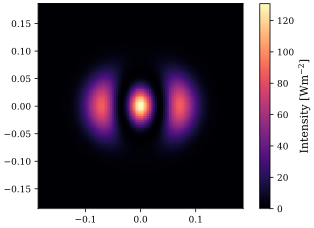

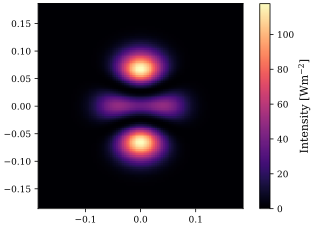

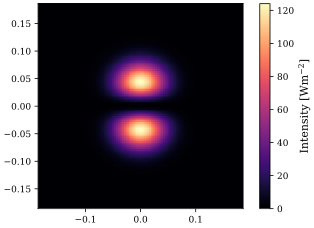

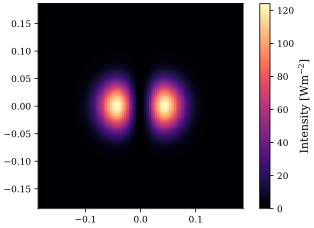

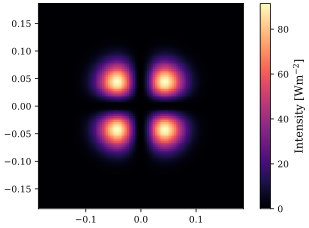

In [9]:
sol_aperture = model.run("eigenmodes(cavity, 0, name='c0')")

for i in range(len(model.homs)):
    plot_field(
        model.homs,
        sol_aperture.eigvectors[:, i],
        model.cavity.source.q
    )

This type of analysis can obviously be expanded to much higher **maxtem**. In such cases, you will find there an essentially an infinite number of optical modes, but larger modes will quickly become more clipped and have large roundtrip losses.

> Note: It should be noted that the order of the eigenmodes is not guaranteed in any way. They may appear to be sensibly organised in simple cases, but when more complex systems are studied they will jump around. This makes analysing the eigenmode infornation somewhat challenging as you must sort them by some appropriate metric for analysing them.